# Reading Data

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from pandas.plotting import parallel_coordinates

In [2]:
data_path = '../data/'
go_data_path = '../data/go_downloads/'

## Read Metadata CSV

In [3]:
# Get and clean project meta data
meta_df = pd.read_csv("../data/project_metadata_functional.csv")

# Make column names neater
meta_df.columns = meta_df.columns.str.strip()
meta_df.columns = meta_df.columns.str.lower()
meta_df.columns = meta_df.columns.str.replace(' ', '_')
meta_df.rename(columns={'sample_details':'zone'}, inplace=True)

# Split lat and long into seperate columns
meta_df['lat'] = meta_df['lat/long'].str.split(',', 1).str[0]
meta_df['long'] = meta_df['lat/long'].str.split(',', 1).str[1]

# Clean up 'region' and 'zone' columns
meta_df['region'] = meta_df['region'].str.strip()
meta_df['zone'] = meta_df['zone'].str.strip()

# Indicate categorical data
meta_df['region'] = meta_df['region'].astype('category')
meta_df['zone'] = meta_df['zone'].astype('category')
meta_df['run_id'] = meta_df['run_id'].astype('category')

# Drop a few categories
meta_df.drop(
    ['downloaded','link_to_info', 'student', 'lat/long'],
    axis=1, inplace=True)

# Display first 3 items
display("Metadata (Head):", meta_df.head(n=3))

'Metadata (Head):'

,region,run_id,filename,zone,depth_(m),temp_(c),chlorophyl_(mg_chl/m3),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu),lat,long
0,Southern Ocean (near Antarctica),ERR599104,ERR599104_MERGED_FASTQ_GO.csv,deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
1,Southern Ocean (near Antarctica),ERR599090,ERR599090_MERGED_FASTQ_GO.csv,surface water layer,5,0.67108,0.065273,27.501159,343.437300,34.353880,-62.0385,-49.5290
2,Southern Ocean (near Antarctica),ERR599008,ERR599008_MERGED_FASTQ_GO.csv,mesopelagic zone,790,0.45883,0.010087,38.821249,203.839400,34.679960,-61.9689,-49.5017


## Read GO Annotation CSVs

In [4]:
# Define helper function for parsing CSVs
def get_df(idx):
    filenames = meta_df['filename']
    names = ['go_id', 'name', 'namespace', 'read_count']

    # Read GO csv (for given index)
    filepath = f"{go_data_path}{filenames[idx]}"
    df = pd.read_csv(
        filepath, header=None, names=names)
    
    # Add run_id column
    df.insert(0, 'run_id', meta_df['run_id'][idx])
    
    # Sort by read_count
    df.sort_values('read_count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Add read_percent column, based on read_count
    read_sum = df['read_count'].sum()
    df['read_percent'] = (df['read_count']/read_sum)
    
    # Drop some columns
    df.drop(['go_id','read_count'], axis=1, inplace=True)
    
    # Select only top 30 results
    # df = df.iloc[:30,:]
    return df

# Call helper function with all GO annotations,
# merging resulting dataframes together
df = get_df(0)
for i in range(1, len(meta_df)):
    new_df = get_df(i)
    df = pd.concat([df, new_df])
df.reset_index(drop=True, inplace=True)
    
# Indicate categorical data
df['run_id'] = df['run_id'].astype('category')
df['namespace'] = df['namespace'].astype('category')

# Display
display("GO Annotations (head & tail):", df.head(), df.tail())

'GO Annotations (head & tail):'

,run_id,name,namespace,read_percent
0,ERR599104,catalytic activity,molecular_function,0.066795
1,ERR599104,oxidation-reduction process,biological_process,0.058572
2,ERR599104,ATP binding,molecular_function,0.054929
3,ERR599104,metabolic process,biological_process,0.040067
4,ERR599104,membrane,cellular_component,0.031069


,run_id,name,namespace,read_percent
24086,ERR599031,vesicle docking involved in exocytosis,biological_process,6.473864e-08
24087,ERR599031,mitochondrial pyruvate transport,biological_process,6.473864e-08
24088,ERR599031,galactosylceramide catabolic process,biological_process,6.473864e-08
24089,ERR599031,glycerol ether metabolic process,biological_process,6.473864e-08
24090,ERR599031,cutinase activity,molecular_function,6.473864e-08


## Merge the Two DataFrames Together

In [5]:
# Merge, using run_id
full_df = df.merge(meta_df)
full_df.drop('filename', axis=1, inplace=True)

# Truncate function names at 35 characters
# full_df.name = full_df.name.apply(
#     lambda x: (x[:35] + '...') if len(x) > 38 else x)

display('Full DataFrame (head & tail):', full_df.head(), full_df.tail())

'Full DataFrame (head & tail):'

,run_id,name,namespace,read_percent,region,zone,depth_(m),temp_(c),chlorophyl_(mg_chl/m3),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu),lat,long
0,ERR599104,catalytic activity,molecular_function,0.066795,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
1,ERR599104,oxidation-reduction process,biological_process,0.058572,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
2,ERR599104,ATP binding,molecular_function,0.054929,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
3,ERR599104,metabolic process,biological_process,0.040067,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
4,ERR599104,membrane,cellular_component,0.031069,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139


,run_id,name,namespace,read_percent,region,zone,depth_(m),temp_(c),chlorophyl_(mg_chl/m3),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu),lat,long
24086,ERR599031,vesicle docking involved in exocytosis,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24087,ERR599031,mitochondrial pyruvate transport,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24088,ERR599031,galactosylceramide catabolic process,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24089,ERR599031,glycerol ether metabolic process,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24090,ERR599031,cutinase activity,molecular_function,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851


## Make Heat Maps

In [6]:
# Only use the first 30 items
df = full_df.groupby('run_id').head(n=30)

# Truncate function names at 35 characters
# df.name = df.name.apply(
#     lambda x: (x[:35] + '...') if len(x) > 38 else x)

### All Samples

Run ID,ERR598948,ERR598980,ERR598992,ERR598995,ERR598999,ERR599008,ERR599031,ERR599078,ERR599090,ERR599104,ERR599142
Functional Category Name,,,,,,,,,,,
ATP binding,0.054676,0.051896,0.056190,0.056112,0.052368,0.051243,0.051192,0.056278,0.054078,0.054929,0.057116
DNA binding,0.020949,0.019473,0.020239,0.021562,0.020241,0.020993,0.022989,0.020380,0.019620,0.019859,0.019743
GTP binding,0.006697,0.006632,0.007168,0.006722,0.006666,0.006579,0.006832,0.007035,0.006799,0.006981,0.007332
RNA binding,0.007409,0.006670,0.007577,0.007755,0.006823,0.006448,0.006309,0.007498,0.007670,0.007661,0.007681
aminoacyl-tRNA ligase activity,0.009832,0.009378,0.010227,0.009812,0.009381,0.008689,0.009296,0.010078,0.009636,0.009400,0.010151


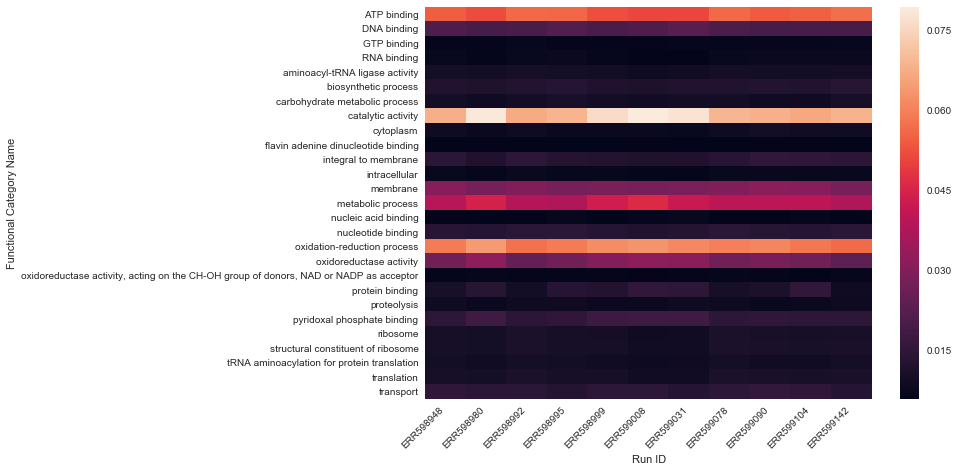

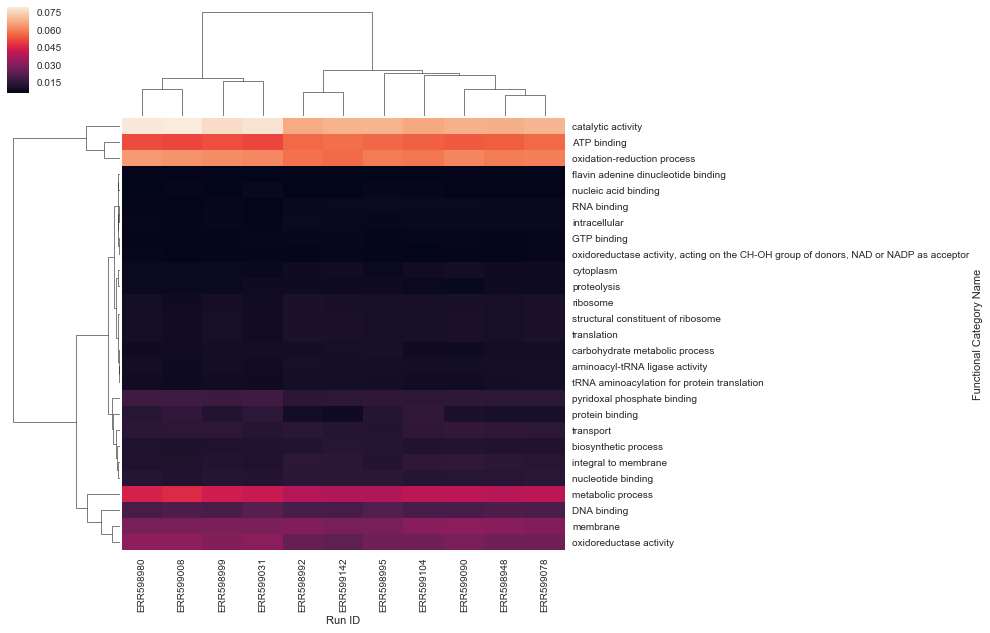

In [7]:
# rearrange relevent data
data = df.pivot(index='name', columns='run_id', values='read_percent')
data.columns.name = 'Run ID'
data.index.name = "Functional Category Name"
data = data.dropna(axis=0)
display(data.head())

# Make heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ax=ax, data=data)
fig.autofmt_xdate(rotation=45)
fig.savefig('imgs/heat/heat_all.png', bbox_inches='tight', dpi=300)

# Make clustermap
ax = sns.clustermap(data=data)
ax.savefig('imgs/cluster/cluster_all', dpi=300)

### By region

Run ID,Arabian Sea,North Atlantic (off the coast of Portugal),North Pacific,South Pacific (near the Marquesas),Southern Ocean (near Antarctica)
Functional Category Name,,,,,
ATP binding,0.051192,0.056278,0.055041,0.054411,0.053416
DNA binding,0.022989,0.020380,0.020260,0.020477,0.020157
GTP binding,0.006832,0.007035,0.006895,0.006844,0.006786
RNA binding,0.006309,0.007498,0.007368,0.007270,0.007260
aminoacyl-tRNA ligase activity,0.009296,0.010078,0.009780,0.009814,0.009242


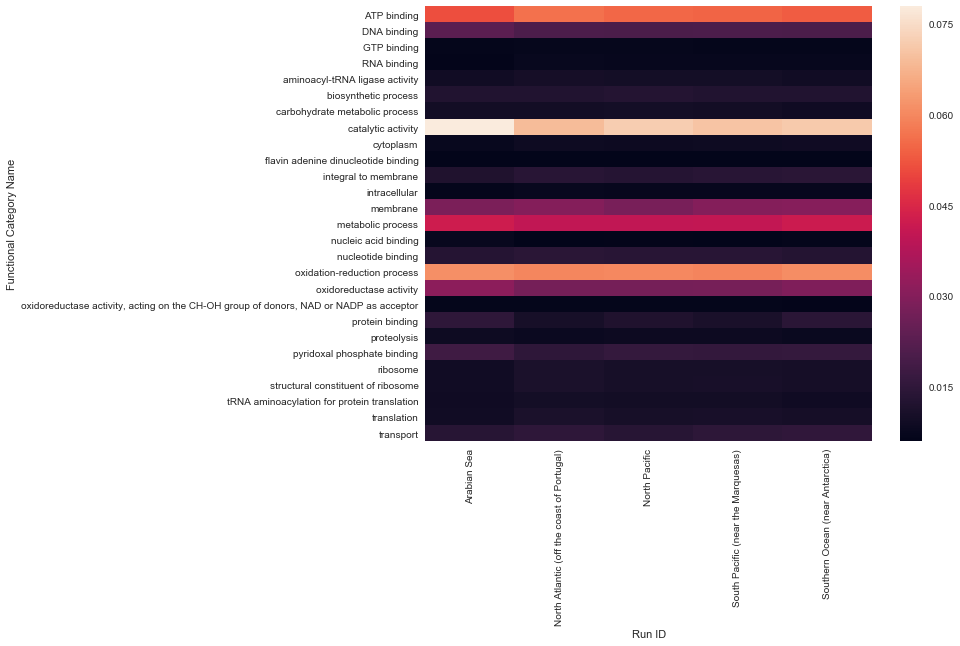

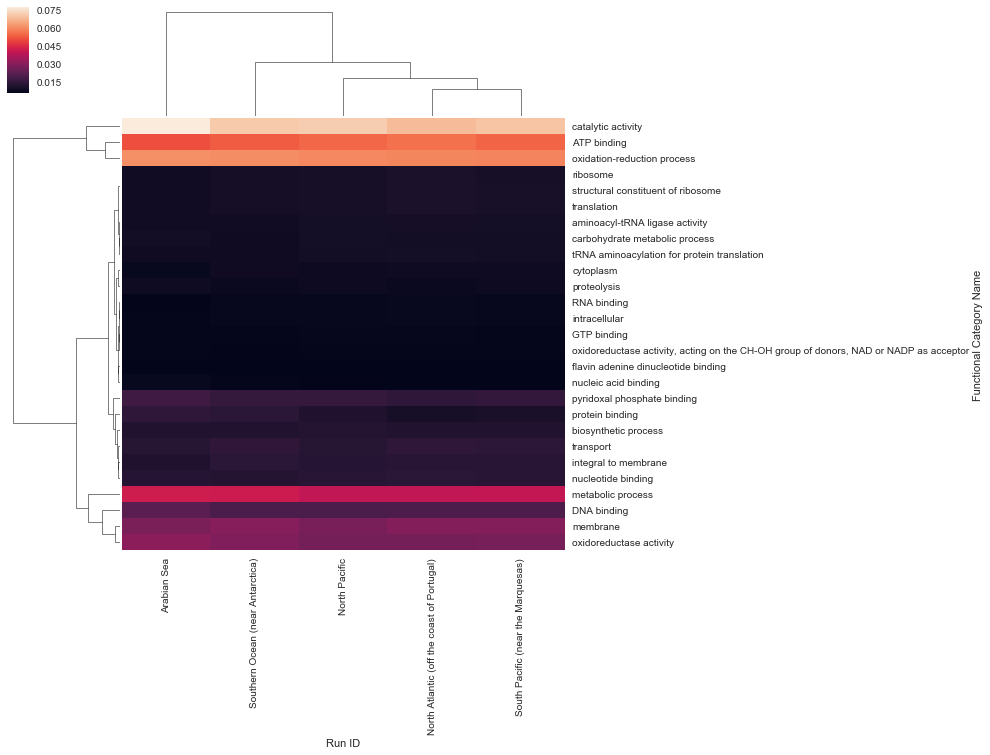

In [8]:
# Rearrange data; taking mean of regions
data = df.pivot_table(index='name', columns='region', aggfunc={'read_percent':'mean'})
data.columns = data.columns.droplevel(0)
data.columns.name = 'Run ID'
data.index.name = "Functional Category Name"
data = data.dropna(axis=0)
display(data.head())

# Make heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ax=ax, data=data)
fig.savefig('imgs/heat/heat_region.png', bbox_inches='tight', dpi=300)

# Make clustermap
ax = sns.clustermap(data=data)
ax.savefig('imgs/cluster/cluster_region', dpi=300)

### By depth

Run ID,deep chlorophyll maximum layer,mesopelagic zone,surface water layer
Functional Category Name,,,
ATP binding,0.055239,0.051674,0.055915
ATPase activity,0.006037,0.006419,0.005981
DNA binding,0.020790,0.020924,0.019995
GTP binding,0.006800,0.006677,0.007083
NAD binding,0.005565,0.005658,0.005751


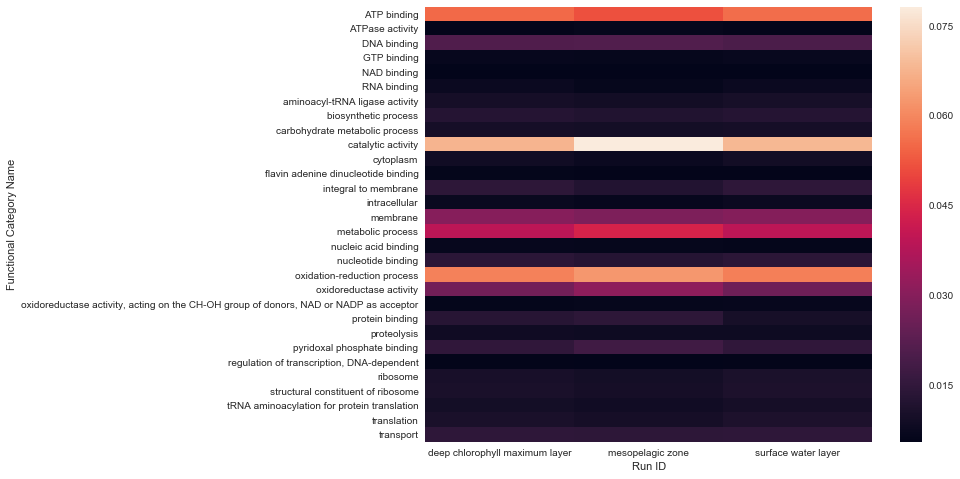

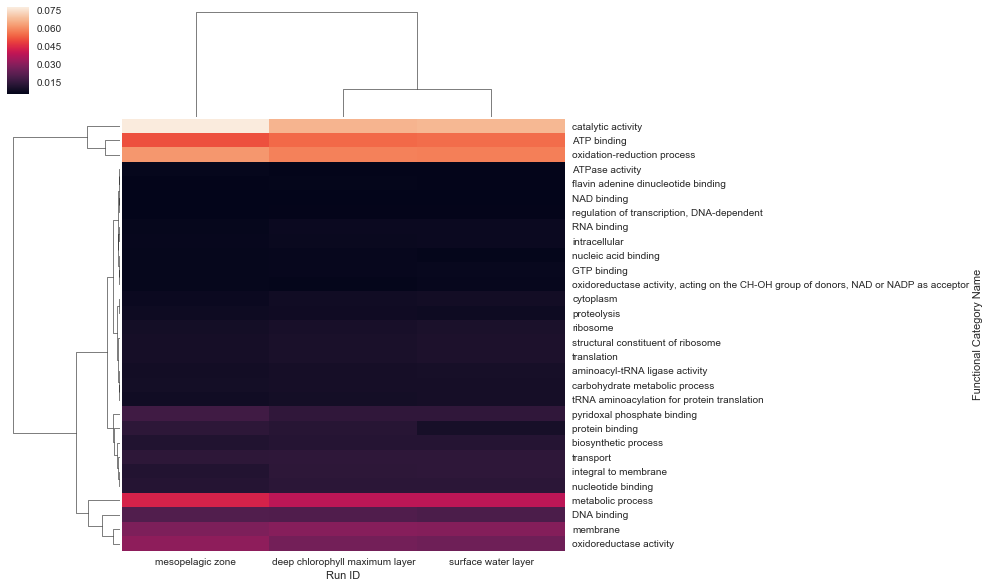

In [9]:
# Rearrange data; taking mean of zones
data = df.pivot_table(index='name', columns='zone', aggfunc={'read_percent':'mean'})
data.columns = data.columns.droplevel(0)
data.columns.name = 'Run ID'
data.index.name = "Functional Category Name"
data = data.dropna(axis=0)
display(data.head())

# Make heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ax=ax, data=data)
fig.savefig('imgs/heat/heat_zone.png', bbox_inches='tight', dpi=300)

# Make clustermap
ax = sns.clustermap(data=data)
ax.savefig('imgs/cluster/cluster_zone', dpi=300)

## Parallel Coordiantes

In [10]:
df.head()

,run_id,name,namespace,read_percent,region,zone,depth_(m),temp_(c),chlorophyl_(mg_chl/m3),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu),lat,long
0,ERR599104,catalytic activity,molecular_function,0.066795,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
1,ERR599104,oxidation-reduction process,biological_process,0.058572,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
2,ERR599104,ATP binding,molecular_function,0.054929,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
3,ERR599104,metabolic process,biological_process,0.040067,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
4,ERR599104,membrane,cellular_component,0.031069,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139


In [11]:
df.pivot(index='run_id', columns='name', values='read_percent')

name,ATP binding,ATPase activity,DNA binding,DNA replication,GTP binding,NAD binding,RNA binding,aminoacyl-tRNA ligase activity,biosynthetic process,carbohydrate metabolic process,...,"oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor",protein binding,proteolysis,pyridoxal phosphate binding,"regulation of transcription, DNA-dependent",ribosome,structural constituent of ribosome,tRNA aminoacylation for protein translation,translation,transport
run_id,,,,,,,,,,,,,,,,,,,,,
ERR598948,0.054676,0.005978,0.020949,NaN,0.006697,NaN,0.007409,0.009832,0.012449,0.009573,...,0.006679,0.010616,0.008563,0.014734,0.005756,0.010300,0.010406,0.009564,0.010408,0.015223
ERR598980,0.051896,0.006241,0.019473,NaN,0.006632,0.005736,0.006670,0.009378,0.011707,0.008987,...,0.006873,0.013605,0.007893,0.018113,NaN,0.009711,0.009797,0.009156,0.009796,0.014267
ERR598992,0.056190,0.005844,0.020239,0.005770,0.007168,0.005620,0.007577,0.010227,0.012785,0.009623,...,0.006759,0.009370,0.008689,0.014446,NaN,0.011087,0.011212,0.009905,0.011214,0.014048
ERR598995,0.056112,0.006044,0.021562,0.007172,0.006722,NaN,0.007755,0.009812,0.013339,0.010523,...,0.006492,0.013317,0.008915,0.015153,NaN,0.010346,0.010452,0.009595,0.010453,0.012943
ERR598999,0.052368,0.006248,0.020241,NaN,0.006666,0.005581,0.006823,0.009381,0.011954,0.009355,...,0.006671,0.012633,0.007935,0.017513,NaN,0.010129,0.010241,0.009164,0.010237,0.014694
ERR599008,0.051243,0.006768,0.020993,NaN,0.006579,NaN,0.006448,0.008689,0.011395,0.009292,...,0.006375,0.015591,0.008150,0.018099,NaN,0.009035,0.009143,0.008473,0.009143,0.014790
ERR599031,0.051192,NaN,0.022989,NaN,0.006832,NaN,0.006309,0.009296,0.012222,0.009423,...,0.006588,0.014777,0.008583,0.018005,0.005779,0.009265,0.009323,0.009039,0.009324,0.013317
ERR599078,0.056278,0.006379,0.020380,0.005784,0.007035,0.005706,0.007498,0.010078,0.012234,0.009586,...,0.006845,0.010258,0.008235,0.014744,NaN,0.011117,0.011234,0.009788,0.011235,0.014743
ERR599090,0.054078,0.005709,0.019620,NaN,0.006799,0.005960,0.007670,0.009636,0.012732,0.008771,...,0.006524,0.011184,0.007600,0.015028,0.005933,0.010762,0.010893,0.009348,0.010893,0.015781


In [12]:
# data = df.pivot_table(index='run_id', columns='name')
# data = data.reset_index(col_level=1)
# data.drop('read_count', axis=1, level=0, inplace=True)
# data.columns = data.columns.droplevel(0)
# data.drop('run_id', axis=1, inplace=True)

In [13]:
data.head()

Run ID,deep chlorophyll maximum layer,mesopelagic zone,surface water layer
Functional Category Name,,,
ATP binding,0.055239,0.051674,0.055915
ATPase activity,0.006037,0.006419,0.005981
DNA binding,0.020790,0.020924,0.019995
GTP binding,0.006800,0.006677,0.007083
NAD binding,0.005565,0.005658,0.005751


In [14]:
# fig, ax = plt.subplots(figsize=(20,10))
# ax = parallel_coordinates(data, class_column='zone')
# fig.savefig('parCo_all.png', bbox_inches='tight', dpi=300)